## Import Libraries

In [44]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

import xgboost

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import mysql.connector
from mysql.connector import Error



***
## Reusable Function

### Save Dataset

In [45]:
# Save Dataset
def save_dataset(dataset, pathWithFilename):
    dataset.to_csv(pathWithFilename)

### Print Dataset Statistics

In [46]:
# Dataset Statistics
def printDatasetStats(dataset):
    print("Dataset Statistics :")
    print("--------------------------------------------------")
    print("Row count : ", dataset.shape[0])
    print("Feature/Column count : ", dataset.shape[1])
    print("First Few Rows : \n", dataset.head())


### Display Column Data Types and number of Null values


In [47]:
# Display Column Data Types and number of Null values
def printColTypeAndNullCount(dataset):
    print("Type of Features/Columns and Null value count")
    print("--------------------------------------------------")
    for index, col in enumerate(dataset.columns):
        print()
        print("Name : ", col)
        print("Total null values : ", dataset.iloc[:, index].isnull().values.sum())
        print("Feature/Column Type : ", dataset[col].dtype)


### Get column indices based on column datatype


In [48]:
# Get column indices based on column datatype
# Params : dataframe - pandas | dtype - "number, string, float64, int, object, all"
# Return : Column and Indices - Dictionary
def getColumnIndicesBasedOnType(dataframe, dtype="all"):
    if dtype == "all":
        columns = dataframe.columns
    else:
        columns = dataframe.select_dtypes(include=[dtype]).columns

    indices = dataframe.columns.get_indexer(columns)
    return {"cols": columns, "indices": indices}


***
## Import Dataset for MySQL Database

In [49]:
db = mysql.connector.connect(
  host="localhost",
  user="root",
  password="root",
  database="employee_churn"
)

cursor = db.cursor()

table = "ibm_employees"
query = "SELECT * FROM " + table

try:
    cursor.execute(query)
    columns = [desc[0] for desc in cursor.description]
    rows = cursor.fetchall()
    initial_dataset = pd.DataFrame(rows, columns=columns)
    dataset = initial_dataset.copy()
    display(dataset)

except Error as err:
    print("Error while loading data from Database : ", err)

cursor.close()
db.close()

,EmployeeNumber,Age,Gender,Education,EducationField,MaritalStatus,JobRole,JobLevel,Department,MonthlyIncome,...,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,YearsWithCurrManager,TrainingTimesLastYear,YearsSinceLastPromotion,DistanceFromHome,WorkLifeBalance,BusinessTravel,Churn
0,1,41,Female,2,Life Sciences,Single,Sales Executive,2,Sales,5993,...,8,6,0,5,1,0,1,4,Travel_Rarely,Yes
1,2,49,Male,1,Life Sciences,Married,Research Scientist,2,Research & Development,5130,...,10,10,3,7,8,1,3,7,Travel_Frequently,No
2,4,37,Male,2,Other,Single,Laboratory Technician,1,Research & Development,2090,...,7,0,3,0,2,0,3,0,Travel_Rarely,Yes
3,5,33,Female,4,Life Sciences,Married,Research Scientist,1,Research & Development,2909,...,8,8,3,0,3,3,3,7,Travel_Frequently,No
4,7,27,Male,1,Medical,Married,Laboratory Technician,1,Research & Development,3468,...,6,2,3,2,2,2,3,2,Travel_Rarely,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,2061,36,Male,2,Medical,Married,Laboratory Technician,2,Research & Development,2571,...,17,5,3,3,23,0,3,2,Travel_Frequently,No
1466,2062,39,Male,1,Medical,Married,Healthcare Representative,3,Research & Development,9991,...,9,7,5,7,6,1,3,7,Travel_Rarely,No
1467,2064,27,Male,3,Life Sciences,Married,Manufacturing Director,2,Research & Development,6142,...,6,6,0,3,4,0,3,2,Travel_Rarely,No
1468,2065,49,Male,3,Medical,Married,Sales Executive,2,Sales,5390,...,17,9,3,8,2,0,2,6,Travel_Frequently,No


***
## Print Dataset Statistics

In [50]:
printDatasetStats(dataset)

Dataset Statistics :
--------------------------------------------------
Row count :  1470
Feature/Column count :  29
First Few Rows : 
    EmployeeNumber  Age  Gender  Education EducationField MaritalStatus  \
0               1   41  Female          2  Life Sciences        Single   
1               2   49    Male          1  Life Sciences       Married   
2               4   37    Male          2          Other        Single   
3               5   33  Female          4  Life Sciences       Married   
4               7   27    Male          1        Medical       Married   

                 JobRole  JobLevel              Department  MonthlyIncome  \
0        Sales Executive         2                   Sales           5993   
1     Research Scientist         2  Research & Development           5130   
2  Laboratory Technician         1  Research & Development           2090   
3     Research Scientist         1  Research & Development           2909   
4  Laboratory Technician         1

***
## Data Preprocessing

### Display Column Data Types and number of Null values


In [51]:
printColTypeAndNullCount(dataset)

Type of Features/Columns and Null value count
--------------------------------------------------

Name :  EmployeeNumber
Total null values :  0
Feature/Column Type :  int64

Name :  Age
Total null values :  0
Feature/Column Type :  int64

Name :  Gender
Total null values :  0
Feature/Column Type :  object

Name :  Education
Total null values :  0
Feature/Column Type :  int64

Name :  EducationField
Total null values :  0
Feature/Column Type :  object

Name :  MaritalStatus
Total null values :  0
Feature/Column Type :  object

Name :  JobRole
Total null values :  0
Feature/Column Type :  object

Name :  JobLevel
Total null values :  0
Feature/Column Type :  int64

Name :  Department
Total null values :  0
Feature/Column Type :  object

Name :  MonthlyIncome
Total null values :  0
Feature/Column Type :  int64

Name :  PercentSalaryHike
Total null values :  0
Feature/Column Type :  int64

Name :  JobInvolvement
Total null values :  0
Feature/Column Type :  int64

Name :  JobSatisfaction
T

***
### Drop Null rows with threshold null values and Irrelevant Columns

In [52]:
# Drop Irrelevant and Redundant columns
# Params : dataframe - pandas | colnames - list
# Return : dataframe - pandas
def dropIrrCols(dataframe, colnames):
    return dataframe.drop(columns=colnames)

irrelevantColumns = ["EmployeeNumber", "StandardHours"]
dataset = dropIrrCols(dataset, irrelevantColumns)
print("Columns dropped : ", ", ".join(irrelevantColumns))
print()

# Drop Null rows with threshold null values
# Params : dataframe - pandas | threshold - int
# Return : dataframe - pandas
def dropNullRows(dataframe, threshold=50):
    print("Drop Threshold : ", threshold)
    return dataframe[
        dataframe.isnull().sum(axis=1) < (dataframe.shape[1]) * (threshold / 100)
    ]

threshold = 50
dataset = dropNullRows(dataset, threshold)
print("Dataset rows count after drop : ", dataset.shape[0])
print("Number of rows dropped : ", initial_dataset.shape[0] - dataset.shape[0])

Columns dropped :  EmployeeNumber, StandardHours

Drop Threshold :  50
Dataset rows count after drop :  1470
Number of rows dropped :  0


***
### Handle Null values with Numerical columns


In [53]:
# Handle Null values with Numerical columns
# Params : dataframe - pandas | operation - string (mean, constant, median, most_frequent) | colType - string (number, string, all)
# Return : dataframe - pandas
def handleNullValues(dataframe, operation="mean", colType="number"):
    imputer = SimpleImputer(missing_values=np.nan, strategy=operation)
    cols = getColumnIndicesBasedOnType(dataframe, colType)
    imputer.fit(dataframe.iloc[:, cols["indices"]])
    dataframe.iloc[:, cols["indices"]] = imputer.transform(
        dataframe.iloc[:, cols["indices"]]
    )

    print("Null values replace map (" + operation + ") :")
    for index, col in enumerate(cols["cols"]):
        print("\t" + col.strip() + " -> ", imputer.statistics_[index])
    print("--------------------------------------------------\n")
    return dataframe


nullOperation = "most_frequent"
nullOpDtypes = "all"
dataset = handleNullValues(dataset, nullOperation, nullOpDtypes)

# Display Column Data Types and number of Null values after operation
printColTypeAndNullCount(dataset)

Null values replace map (most_frequent) :
	Age ->  35
	Gender ->  Male
	Education ->  3
	EducationField ->  Life Sciences
	MaritalStatus ->  Married
	JobRole ->  Sales Executive
	JobLevel ->  1
	Department ->  Research & Development
	MonthlyIncome ->  2342
	PercentSalaryHike ->  11
	JobInvolvement ->  3
	JobSatisfaction ->  4
	EnvironmentSatisfaction ->  3
	RelationshipSatisfaction ->  3
	PerformanceRating ->  3
	OverTime ->  No
	NumCompaniesWorked ->  1
	TotalWorkingYears ->  10
	YearsAtCompany ->  5
	YearsInCurrentRole ->  2
	YearsWithCurrManager ->  2
	TrainingTimesLastYear ->  2
	YearsSinceLastPromotion ->  0
	DistanceFromHome ->  3
	WorkLifeBalance ->  2
	BusinessTravel ->  Travel_Rarely
	Churn ->  No
--------------------------------------------------

Type of Features/Columns and Null value count
--------------------------------------------------

Name :  Age
Total null values :  0
Feature/Column Type :  int64

Name :  Gender
Total null values :  0
Feature/Column Type :  object



***
### Categorical Encoding


In [54]:
# Categorical Encoding

def encoder(encoderObj, colName, dataframe):
    encoderObj = LabelEncoder()
    dataframe[colName] = encoderObj.fit_transform(dataframe[colName])
    # print("Encoded Gender of the patient : \n", dataframe["Gender of the patient"])
    print("Map of Encoded Values of " + colName + " : \n")
    for enVal, origVal in enumerate(encoderObj.classes_):
        print(enVal, " -> ", origVal)
    print("--------------------------------------------------")

def encodeColumns(dataframe):
    # Gender Encoder
    genderEncoder = LabelEncoder()
    encoder(genderEncoder, "Gender", dataframe)

    # EducationField Encoder
    eduFieldEncoder = LabelEncoder()
    encoder(eduFieldEncoder, "EducationField", dataframe)

    # MaritalStatus Encoder
    maritalStatusEncoder = LabelEncoder()
    encoder(maritalStatusEncoder, "MaritalStatus", dataframe)

    # JobRole Encoder
    jobRoleEncoder = LabelEncoder()
    encoder(jobRoleEncoder, "JobRole", dataframe)

    # Department Encoder
    departmentEncoder = LabelEncoder()
    encoder(departmentEncoder, "Department", dataframe)

    # Department Encoder
    departmentEncoder = LabelEncoder()
    encoder(departmentEncoder, "Department", dataframe)

    # BusinessTravel Encoder
    businessTravelEncoder = LabelEncoder()
    encoder(businessTravelEncoder, "BusinessTravel", dataframe)

    # OverTime Encoder
    dataframe['OverTime'] = dataframe['OverTime'].map({"Yes": 1, "No": 0})
    print("Map of Encoded Values 'OverTime' : \n")
    print("Yes -> 1")
    print("No -> 0")

    # Churn Encoder
    dataframe['Churn'] = dataframe['Churn'].map({"Yes": 1, "No": 0})
    print("Map of Encoded Values 'Churn' : \n")
    print("Yes -> 1")
    print("No -> 0")

    return dataframe


dataset = encodeColumns(dataset)
# dataset_path = "./encoded.csv"
# save_dataset(dataset, dataset_path)

Map of Encoded Values of Gender : 

0  ->  Female
1  ->  Male
--------------------------------------------------
Map of Encoded Values of EducationField : 

0  ->  Human Resources
1  ->  Life Sciences
2  ->  Marketing
3  ->  Medical
4  ->  Other
5  ->  Technical Degree
--------------------------------------------------
Map of Encoded Values of MaritalStatus : 

0  ->  Divorced
1  ->  Married
2  ->  Single
--------------------------------------------------
Map of Encoded Values of JobRole : 

0  ->  Healthcare Representative
1  ->  Human Resources
2  ->  Laboratory Technician
3  ->  Manager
4  ->  Manufacturing Director
5  ->  Research Director
6  ->  Research Scientist
7  ->  Sales Executive
8  ->  Sales Representative
--------------------------------------------------
Map of Encoded Values of Department : 

0  ->  Human Resources
1  ->  Research & Development
2  ->  Sales
--------------------------------------------------
Map of Encoded Values of Department : 

0  ->  0
1  ->  1
2  ->

### Novelity Features | Interest/Income Ratio and Performance/Experience Ratio 

Interest/Income Ratio = (Job Involvement * Job Satisfaction) / (Monthly Income * Salary Hike * Work Life Balance)

Performance/Experience Ratio = (Performance Rating * Job Involvement) / (Total Working Years * Training Times Last Year * Work Life Balance)


In [55]:
# Interest/Income Ratio
novelty_frame = dataset.copy()
workLifeBalanceMin = dataset[dataset['WorkLifeBalance'] > 0]['WorkLifeBalance'].min()
novelty_frame["WorkLifeBalance"] = novelty_frame['WorkLifeBalance'].replace(0, workLifeBalanceMin)

dataset["InterestIncomeRatio"] = ((dataset["JobInvolvement"] * dataset["JobSatisfaction"]) / ((dataset["MonthlyIncome"] / 10000) * dataset["PercentSalaryHike"] * novelty_frame["WorkLifeBalance"])).astype(float)

# Performance/Experience Ratio
totalWorkingYearsMin = dataset[dataset['TotalWorkingYears'] > 0]['TotalWorkingYears'].min()
novelty_frame["TotalWorkingYears"] = novelty_frame['TotalWorkingYears'].replace(0, totalWorkingYearsMin)

dataset["PerformanceExperienceRatio"] = ((dataset["PerformanceRating"] * dataset["JobInvolvement"]) / (novelty_frame["TotalWorkingYears"] * dataset["TrainingTimesLastYear"] * novelty_frame["WorkLifeBalance"])).astype(float)

display(dataset)
# dataset.to_csv("./NewFeatures.csv")

def moveColumnToEnd(colname, dataframe):
    column = dataframe.pop(colname)
    dataframe[colname] = column

moveColumnToEnd("Churn", dataset)


,Age,Gender,Education,EducationField,MaritalStatus,JobRole,JobLevel,Department,MonthlyIncome,PercentSalaryHike,...,YearsInCurrentRole,YearsWithCurrManager,TrainingTimesLastYear,YearsSinceLastPromotion,DistanceFromHome,WorkLifeBalance,BusinessTravel,Churn,InterestIncomeRatio,PerformanceExperienceRatio
0,41,0,2,1,2,7,2,2,5993,11,...,0,5,1,0,1,4,2,1,0.455076,0.281250
1,49,1,1,1,1,6,2,1,5130,23,...,3,7,8,1,3,7,1,0,0.048430,0.014286
2,37,1,2,4,2,2,1,1,2090,15,...,3,0,2,0,3,0,2,1,1.913876,0.428571
3,33,0,4,1,1,6,1,1,2909,11,...,3,0,3,3,3,7,1,0,0.401798,0.053571
4,27,1,1,3,1,2,1,1,3468,12,...,3,2,2,2,3,2,2,0,0.720877,0.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,1,2,3,1,2,2,1,2571,17,...,3,3,23,0,3,2,1,0,1.830370,0.015345
1466,39,1,1,3,1,0,3,1,9991,15,...,5,7,6,1,3,7,2,0,0.019065,0.015873
1467,27,1,3,1,1,4,2,1,6142,20,...,0,3,4,0,3,2,2,0,0.325627,0.333333
1468,49,1,3,3,1,7,2,2,5390,14,...,3,8,2,0,2,6,1,0,0.088347,0.029412


***
### Outlier Detection and Handeling


In [56]:
# Outlier Detection
def outlierDetection(dataframe):
    outliers_dict = {}

    for col in dataframe.columns:
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        specificColumnData = dataframe[col]
        outliers = specificColumnData[(dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)]
        outliers_dict[col] = outliers

    for col in outliers_dict:
        print(f"\nOutliers in column '{col}':\n", outliers_dict[col])
        print("--------------------------------")
    
    return outliers_dict, True


In [57]:
# Outlier Removal
def outlierRemoval(dataframe):
    cleanDataframe = dataframe.copy()

    for col in dataframe.columns:
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 2.5 * IQR
        upper_bound = Q3 + 2.5 * IQR

        cleanDataframe = cleanDataframe[(cleanDataframe[col] >= lower_bound) & (cleanDataframe[col] <= upper_bound)]
    
    return cleanDataframe


In [58]:
# Visualize Outlier Detection using Box Plot
def boxPlotOutliers(dataframe):
    for col in dataframe.columns:
        plt.figure(figsize=(15, 6))
        sns.boxplot(data=dataframe[col], orient='h')
        plt.title("Boxplot of Column : " + col)
        plt.tight_layout()
        plt.show()

In [59]:
# Visualize Outlier Detection using Scatter Plot

def scatterPlotOutliers(dataframe, outliers):
    for col in dataframe.columns:
        plt.figure(figsize=(10, 5))
        plt.scatter(dataframe.index, dataframe[col], color="blue", label="Normal")
        plt.scatter(outliers[col].index, outliers[col], color="red", label="Outliers")
        plt.title("Scatter Plot with Outliers in column : " + col)
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.grid(True)
        plt.legend()
        plt.show()

In [ ]:
# Detect Outliers
outliers = outlierDetection(dataset)

print("\n--------------------------------------------------")
print("Box Plots")
boxPlotOutliers(dataset)

# print("\n--------------------------------------------------")
# print("Scatter Plots")
# scatterPlotOutliers(dataset, outliers)

# # Remove Outliers
# dataset = outlierRemoval(dataset)
# printDatasetStats(dataset)

***
## Feature Correlation

### Correlation matrix

                                 Age    Gender  Education  EducationField  \
Age                         1.000000 -0.036311   0.208034       -0.040873   
Gender                     -0.036311  1.000000  -0.016547       -0.002504   
Education                   0.208034 -0.016547   1.000000       -0.039592   
EducationField             -0.040873 -0.002504  -0.039592        1.000000   
MaritalStatus              -0.095029 -0.047183   0.004053        0.014420   
JobRole                    -0.122427 -0.039723   0.004236        0.015599   
JobLevel                    0.509604 -0.039403   0.101589       -0.044933   
Department                 -0.031882 -0.041583   0.007996        0.013720   
MonthlyIncome               0.497855 -0.031858   0.094961       -0.041070   
PercentSalaryHike           0.003634  0.002733  -0.011111       -0.011214   
JobInvolvement              0.029820  0.017960   0.042438       -0.002655   
JobSatisfaction            -0.004892  0.033252  -0.011296       -0.034401   

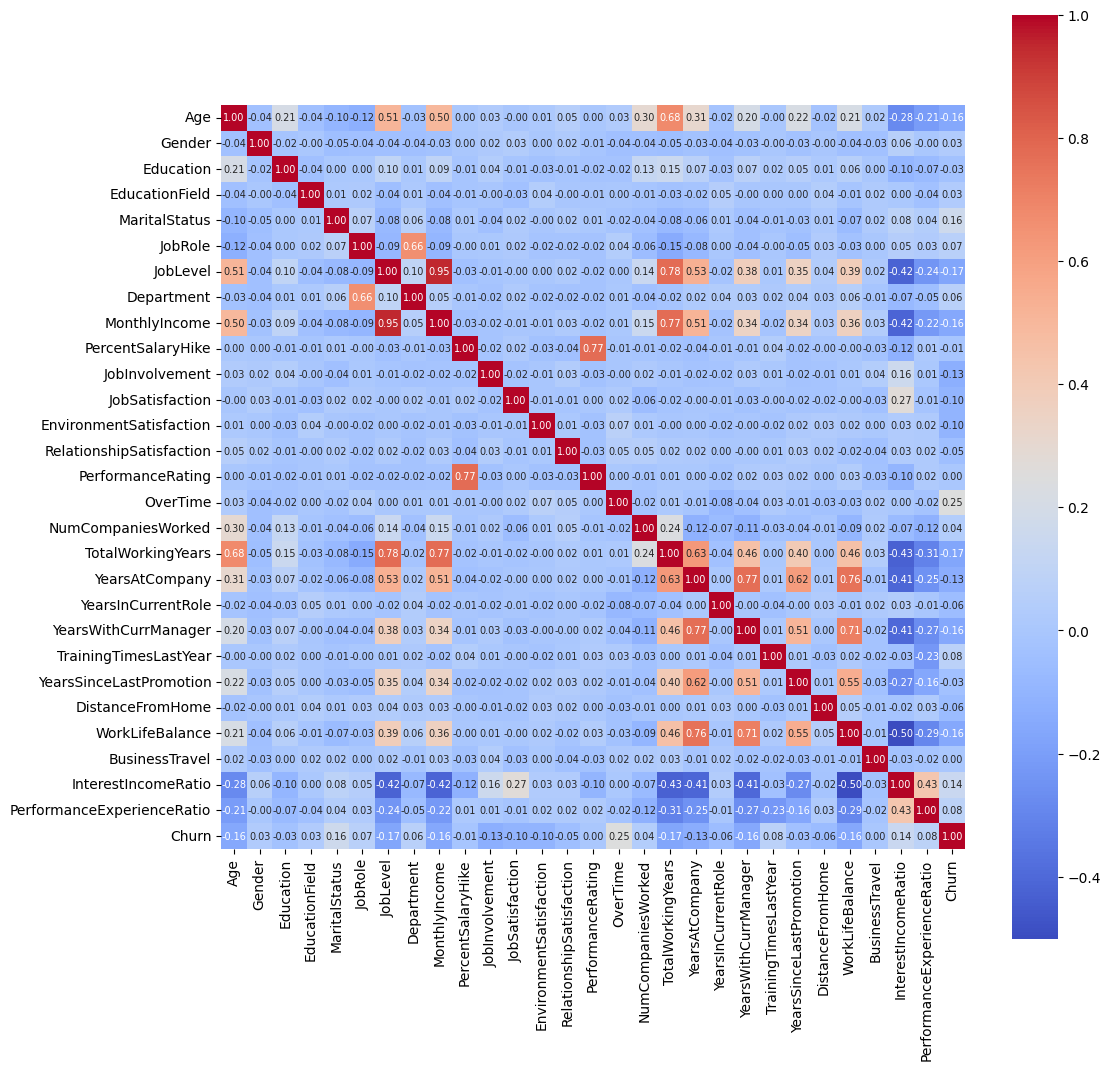

In [ ]:
correlation_matrix = dataset.corr()
print(correlation_matrix)

plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, annot_kws={"size": 7})
plt.show()

***
## Data Visualization

### Age Distribution of Employees

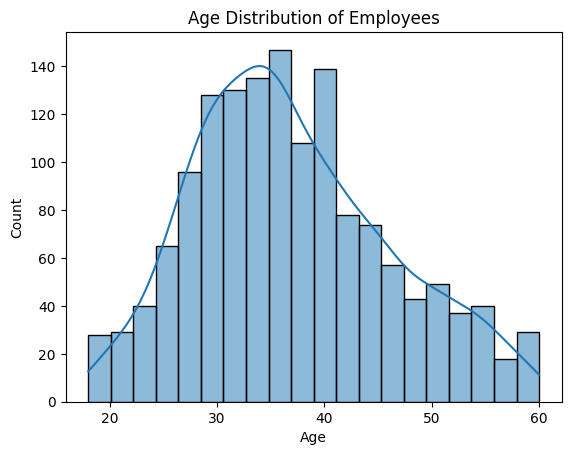

In [ ]:
# Age distribution
sns.histplot(dataset['Age'], bins=20, kde=True)
plt.title('Age Distribution of Employees')
plt.show()

### Total Working Years of Employees

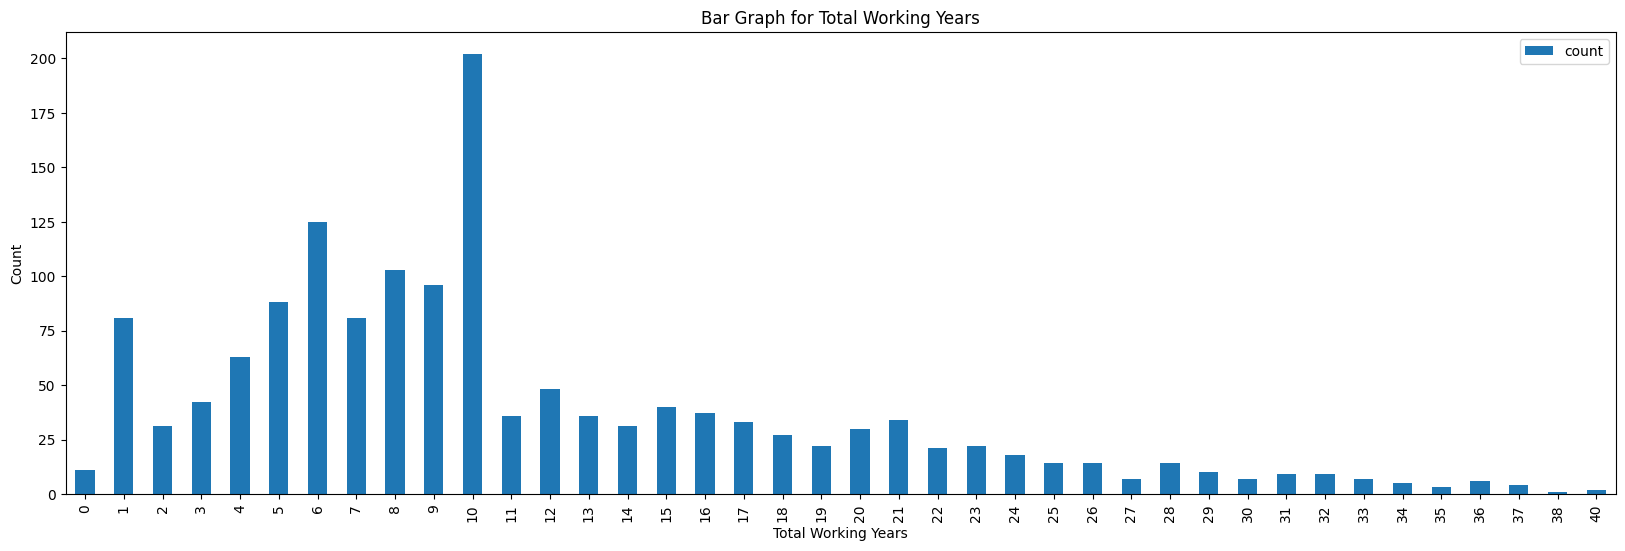

In [ ]:
year_counts = dataset['TotalWorkingYears'].value_counts().sort_index()
plt.figure(figsize=(20, 6))  
year_counts.plot(kind='bar', legend=True)
plt.title('Bar Graph for Total Working Years')
plt.xlabel('Total Working Years')
plt.ylabel('Count')
plt.show()

### Monthly Income vs Age of the Employees

C:\Users\dheer\AppData\Local\Temp\ipykernel_77736\3159951874.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = plotData.groupby('Age')['MonthlyIncome'].mean()


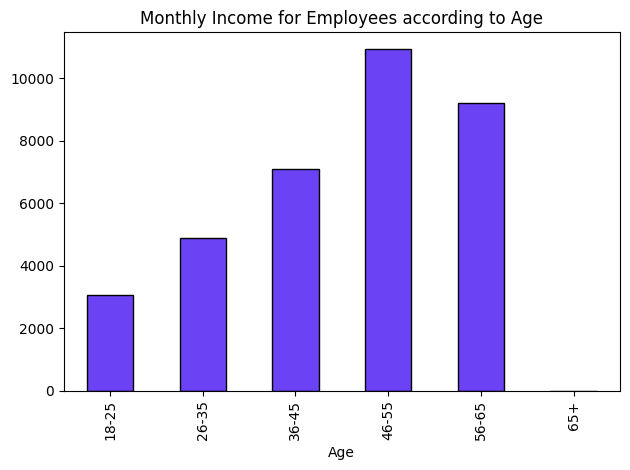

In [ ]:
plotData = dataset.copy()
plotData['Age'] = pd.cut(dataset['Age'], bins=[18, 25, 35, 45, 55, 65, 100], labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])
grouped = plotData.groupby('Age')['MonthlyIncome'].mean()
grouped.plot(kind='bar', color='#6c42f5', edgecolor='black')
plt.title('Monthly Income for Employees according to Age')
plt.tight_layout()
plt.show()

### Impact of Job Satisfaction on Churn

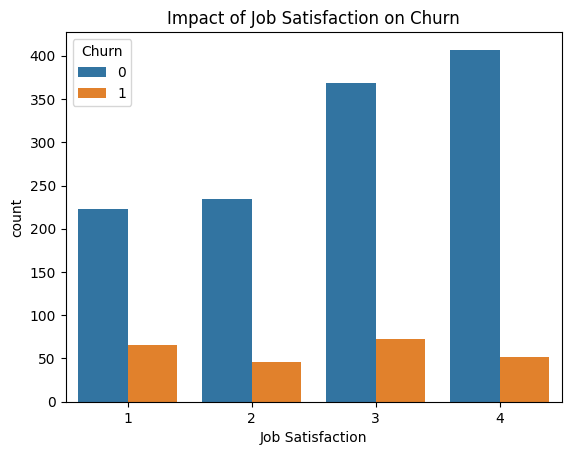

In [ ]:
plotData = dataset.copy()
plotData.groupby('JobSatisfaction')['Churn'].value_counts() 
sns.countplot(x='JobSatisfaction', hue='Churn', data=plotData)
plt.title('Impact of Job Satisfaction on Churn')
plt.xlabel("Job Satisfaction")
plt.show()

### Department Visualization

C:\Users\dheer\AppData\Local\Temp\ipykernel_77736\1600942578.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = ["Research & Development (" + str(department_counts[0]) + ")", "Sales (" + str(department_counts[1]) + ")", "Human Resources (" + str(department_counts[2]) + ")"]


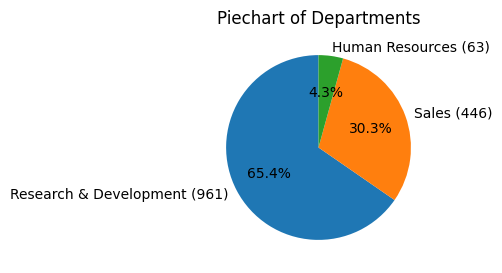

In [ ]:
department_counts = dataset['Department'].map({0: 'Research & Development', 1: 'Sales', 2: 'Human Resources'}).value_counts()
plt.figure(figsize=(3, 3))  
labels = ["Research & Development (" + str(department_counts[0]) + ")", "Sales (" + str(department_counts[1]) + ")", "Human Resources (" + str(department_counts[2]) + ")"]
plt.pie(department_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Piechart of Departments')
plt.show()

### Scatter Plot between Monthly Income and Total Working Years

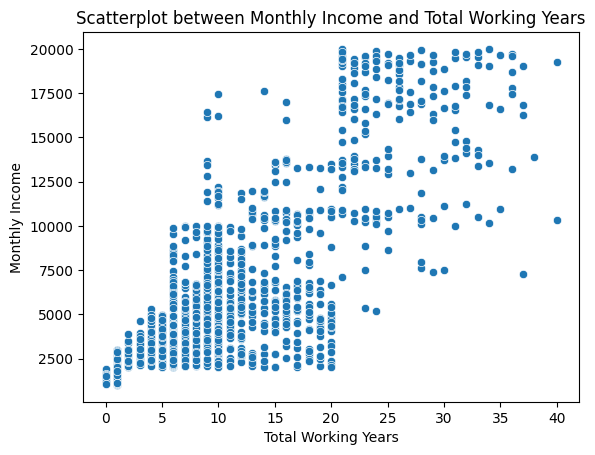

In [ ]:
sns.scatterplot(data=dataset, x='TotalWorkingYears', y='MonthlyIncome')
plt.title('Scatterplot between Monthly Income and Total Working Years')
plt.xlabel('Total Working Years')
plt.ylabel('Monthly Income')
plt.show()

### Over Time worked by employees of different Marital Status 

C:\Users\dheer\AppData\Local\Temp\ipykernel_77736\2220102376.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='MaritalStatus', data=ds_filtered, palette='Set2')


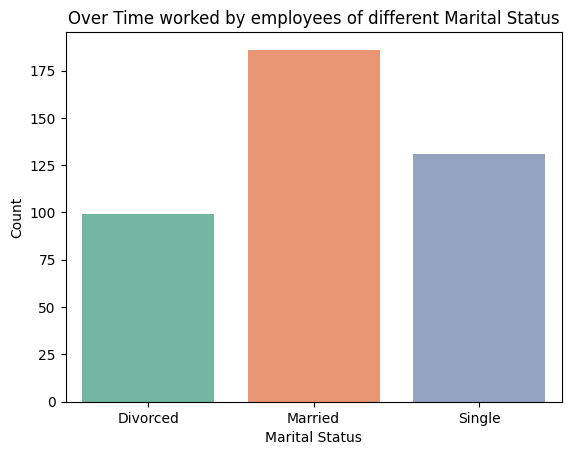

In [ ]:

ds_filtered = dataset[dataset["OverTime"] == 1]
ds_filtered = ds_filtered[["OverTime", "MaritalStatus"].copy()]

sns.countplot(x='MaritalStatus', data=ds_filtered, palette='Set2')
plt.xticks(ticks=[0, 1, 2], labels=['Divorced', 'Married', 'Single'])
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.title('Over Time worked by employees of different Marital Status')
plt.show()

### Regression Plot of Total Working Years and Years At Current Company

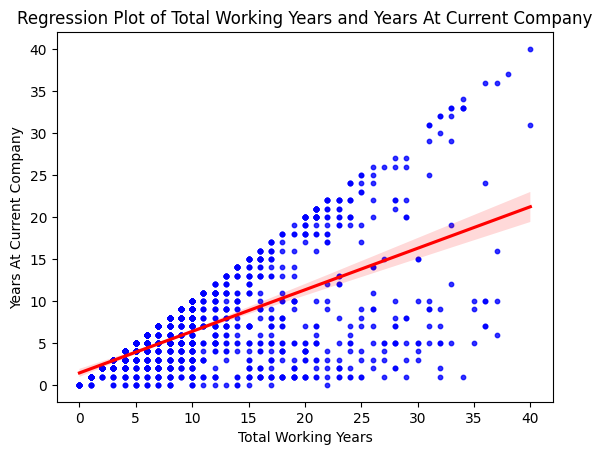

In [ ]:
sns.regplot(x=dataset["TotalWorkingYears"], y=dataset["YearsAtCompany"], scatter_kws={'color': 'blue', 's': 10}, line_kws={'color': 'red'})
plt.title('Regression Plot of Total Working Years and Years At Current Company')
plt.xlabel('Total Working Years')
plt.ylabel('Years At Current Company')
plt.show()

### Scatterplot of Performance to Experience Ratio against Employee Attrition

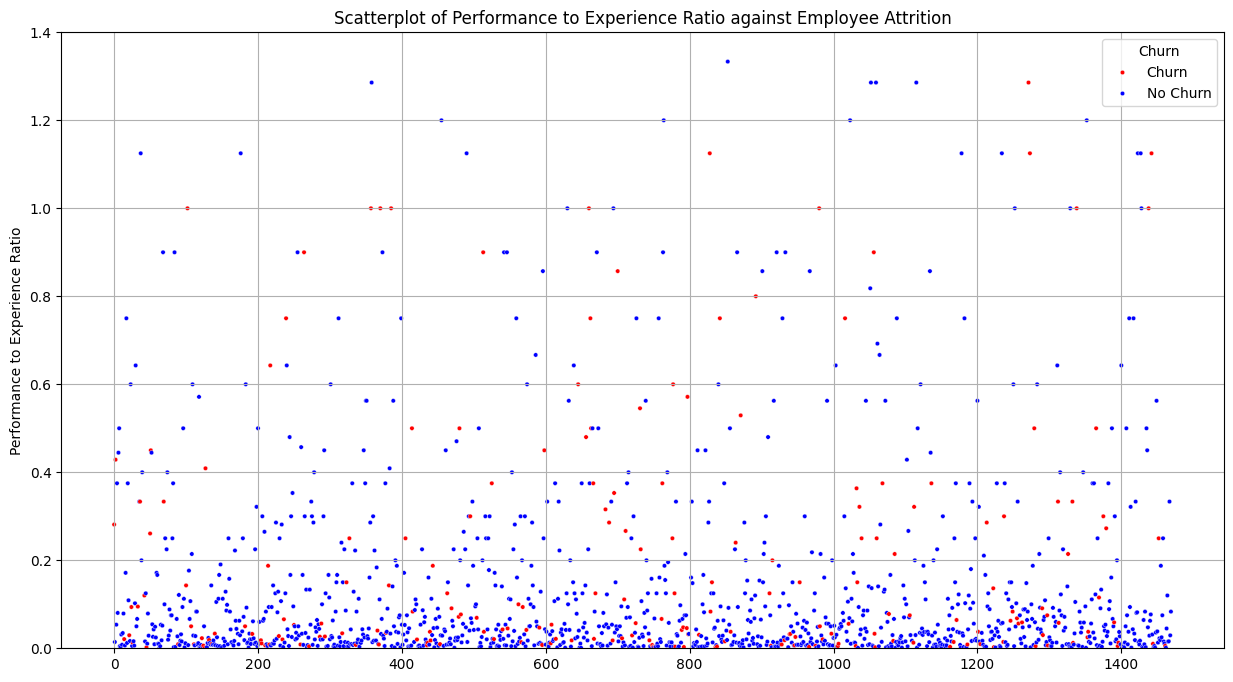

In [ ]:
dataPlot = dataset.copy()
dataPlot['Churn'] = dataPlot['Churn'].map({0: 'No Churn', 1: 'Churn'})

plt.figure(figsize=(15, 8))
sns.scatterplot(data=dataPlot, x=dataPlot.index, y='PerformanceExperienceRatio', hue='Churn', palette={"No Churn": 'blue', "Churn": 'red'}, s=10)
plt.xlabel('')
plt.ylabel('Performance to Experience Ratio')
plt.ylim(0, 1.4)
plt.title('Scatterplot of Performance to Experience Ratio against Employee Attrition')
plt.grid(True)
plt.show()

### Scatterplot of Interest to Income Ratio against Employee Attrition

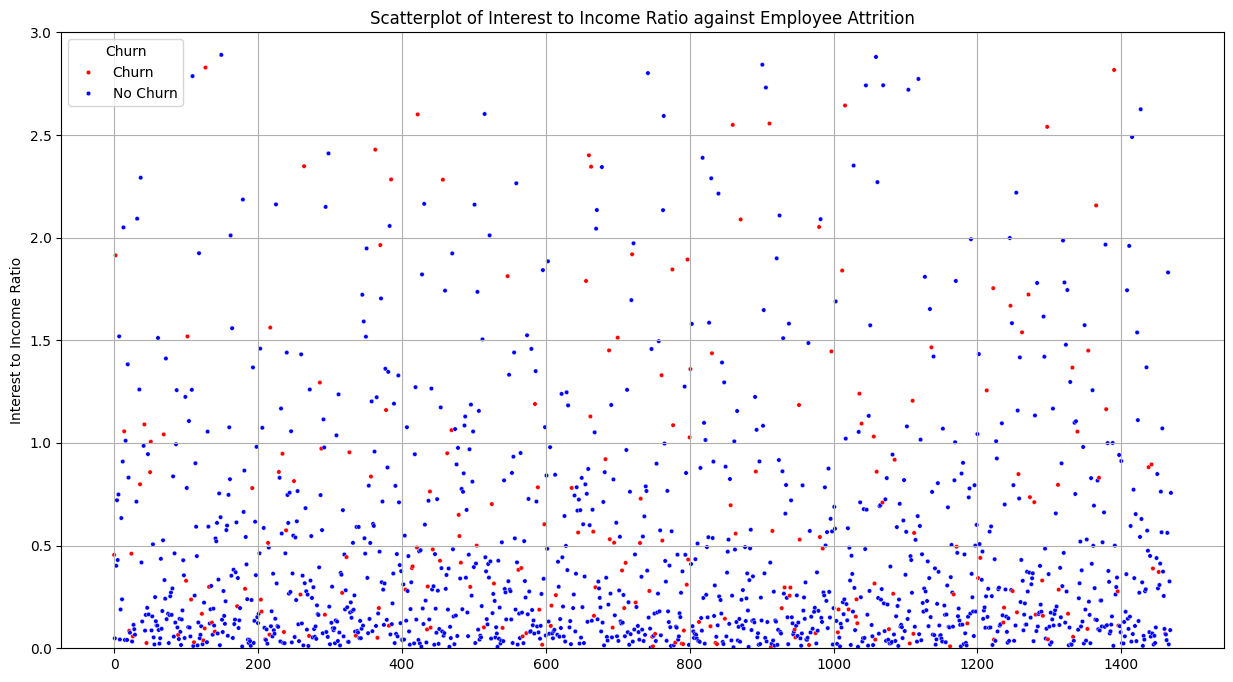

In [ ]:
dataPlot = dataset.copy()
dataPlot['Churn'] = dataPlot['Churn'].map({0: 'No Churn', 1: 'Churn'})

plt.figure(figsize=(15, 8))
sns.scatterplot(data=dataPlot, x=dataPlot.index, y='InterestIncomeRatio', hue='Churn', palette={"No Churn": 'blue', "Churn": 'red'}, s=10)
plt.xlabel('')
plt.ylabel('Interest to Income Ratio')
plt.ylim(0, 3)
plt.title('Scatterplot of Interest to Income Ratio against Employee Attrition')
plt.grid(True)
plt.show()

***
## Dataset Split

In [ ]:
X = dataset.iloc[:, :-1]
Y = dataset.iloc[:, -1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)


***
## Feature Scaling

### Standardization

In [ ]:
colsToScale = ["Age", "MonthlyIncome", "PercentSalaryHike", "TotalWorkingYears", "TrainingTimesLastYear"]
# colIndecies = []
# for index, col in enumerate(dataset.columns):
#     if col in colsToScale:
#         colIndecies.append(index)

sc = StandardScaler()
X_train[colsToScale] = sc.fit_transform(X_train[colsToScale]) # Scale train data 
X_test[colsToScale] = sc.transform(X_test[colsToScale]) # Then use the same object to scale test data

print("Feature Scaling statistics :")
print("Columns scaled : ", colsToScale)
print("--------------------------------------------------")
print("Mean of Standardized Data")
print(X_train[colsToScale].mean()) 
print("--------------------------------------------------")
print("Standard Deviation of Standardized Data")
print(X_train[colsToScale].std()) 

Feature Scaling statistics :
Columns scaled :  ['Age', 'MonthlyIncome', 'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear']
--------------------------------------------------
Mean of Standardized Data
Age                      9.365147e-17
MonthlyIncome            3.021015e-17
PercentSalaryHike        1.480297e-16
TotalWorkingYears        9.063045e-17
TrainingTimesLastYear    4.833624e-17
dtype: float64
--------------------------------------------------
Standard Deviation of Standardized Data
Age                      1.000425
MonthlyIncome            1.000425
PercentSalaryHike        1.000425
TotalWorkingYears        1.000425
TrainingTimesLastYear    1.000425
dtype: float64


***
## Model Training

In [ ]:
print(X_train.info)

<bound method DataFrame.info of            Age  Gender  Education  EducationField  MaritalStatus  JobRole  \
163   2.182386       1          2               1              0        0   
47   -0.010723       1          2               1              1        6   
1085 -0.668656       0          3               1              2        6   
98    2.292042       1          4               3              2        7   
942  -0.120379       0          4               5              1        0   
...        ...     ...        ...             ...            ...      ...   
715  -0.449345       0          4               4              1        0   
905  -0.887967       0          3               1              0        5   
1096  0.318243       1          2               3              2        3   
235   0.647210       0          3               2              1        3   
1061 -1.436244       0          2               1              1        8   

      JobLevel  Department  MonthlyIncome  

### Random Forest

Model : Random Forest
Accuracy:  0.8129251700680272
Precision:  0.6363636363636364
Recall:  0.1206896551724138
F1 Score:  0.2028985507246377
Confusion Matrix: 
 [[232   4]
 [ 51   7]]
ROC-AUC:  0.7814509059029808


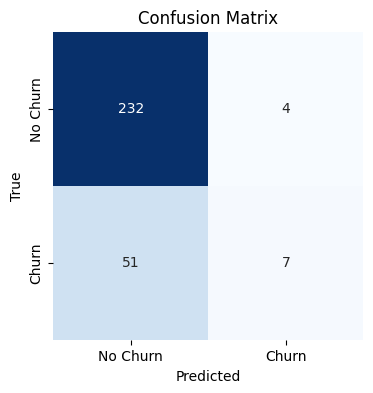

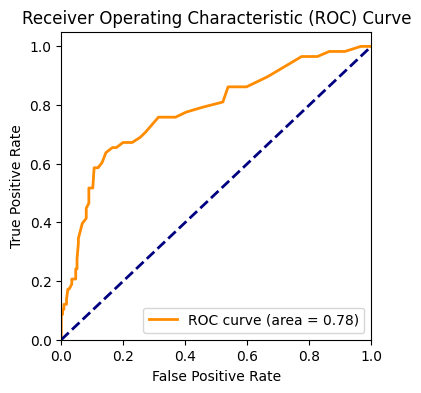

In [ ]:
# Fit the model_name
randomForestModel = RandomForestClassifier()
randomForestModel.fit(X_train, Y_train)
randomForest_predctions = randomForestModel.predict(X_test)

# Performanace Evaluation
rfAccuracy = accuracy_score(Y_test, randomForest_predctions)
rfPrecision = precision_score(Y_test, randomForest_predctions)
rfRecall = recall_score(Y_test, randomForest_predctions)
rfF1 = f1_score(Y_test, randomForest_predctions)

# Confusion Matrix
confusionMatrix = confusion_matrix(Y_test, randomForest_predctions)

# ROC-AUC Calculation
randomForest_classification_probability = randomForestModel.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
roc_auc = roc_auc_score(Y_test, randomForest_classification_probability)

# ROC Curve | false_positive_rate and true_positive_rate
false_pos_rate, true_pos_rate, _ = roc_curve(Y_test, randomForest_classification_probability)
roc_auc = auc(false_pos_rate, true_pos_rate)

print("Model : Random Forest")
print("Accuracy: ", rfAccuracy)
print("Precision: ", rfPrecision)
print("Recall: ", rfRecall)
print("F1 Score: ", rfF1)
print("Confusion Matrix: \n", confusionMatrix)
print("ROC-AUC: ", roc_auc)

# Confusion Matrix Plot
plt.figure(figsize=(4, 4))
sns.heatmap(confusionMatrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curev Plot
plt.figure(figsize=(4, 4))
plt.plot(false_pos_rate, true_pos_rate, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### XGBoost

Model : XGBoost
Accuracy:  0.826530612244898
Precision:  0.6296296296296297
Recall:  0.29310344827586204
F1 Score:  0.4
Confusion Matrix: 
 [[226  10]
 [ 41  17]]
ROC-AUC:  0.7919345412039742

 Feature Importance :


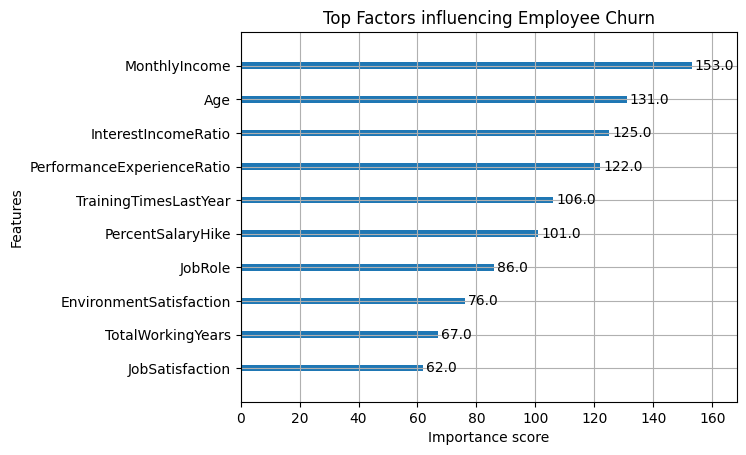

In [ ]:
# Fit the model_name
xgboostModel = xgboost.XGBClassifier()
xgboostModel.fit(X_train, Y_train)
xgboost_predctions = xgboostModel.predict(X_test)

# Performanace Evaluation
xgAccuracy = accuracy_score(Y_test, xgboost_predctions)
xgPrecision = precision_score(Y_test, xgboost_predctions)
xgRecall = recall_score(Y_test, xgboost_predctions)
xgF1 = f1_score(Y_test, xgboost_predctions)

# Confusion Matrix
confusionMatrix = confusion_matrix(Y_test, xgboost_predctions)

# ROC-AUC Calculation
xgboost_classification_probability = xgboostModel.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
roc_auc = roc_auc_score(Y_test, xgboost_classification_probability)

# ROC Curve | false_positive_rate and true_positive_rate
false_pos_rate, true_pos_rate, _ = roc_curve(Y_test, xgboost_classification_probability)
roc_auc = auc(false_pos_rate, true_pos_rate)

print("Model : XGBoost")
print("Accuracy: ", xgAccuracy)
print("Precision: ", xgPrecision)
print("Recall: ", xgRecall)
print("F1 Score: ", xgF1)
print("Confusion Matrix: \n", confusionMatrix)
print("ROC-AUC: ", roc_auc)

# Plot feature importance
print("\n Feature Importance :")
xgboost.plot_importance(xgboostModel, importance_type="weight", max_num_features=10)
plt.title('Top Factors influencing Employee Churn')
plt.show()


### Decision Tree

In [ ]:
# Fit the model
dtModel = DecisionTreeClassifier()
dtModel.fit(X_train, Y_train)
dt_predctions = dtModel.predict(X_test)

# Performanace Evaluation
dtAccuracy = accuracy_score(Y_test, dt_predctions)
dtPrecision = precision_score(Y_test, dt_predctions)
dtRecall = recall_score(Y_test, dt_predctions)
dtF1 = f1_score(Y_test, dt_predctions)

# Confusion Matrix
confusionMatrix = confusion_matrix(Y_test, dt_predctions)

# ROC-AUC Calculation
dt_classification_probability = dtModel.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
roc_auc = roc_auc_score(Y_test, dt_classification_probability)

# ROC Curve | false_positive_rate and true_positive_rate
false_pos_rate, true_pos_rate, _ = roc_curve(Y_test, dt_classification_probability)
roc_auc = auc(false_pos_rate, true_pos_rate)

print("Model : Decision Tree")
print("Accuracy: ", dtAccuracy)
print("Precision: ", dtPrecision)
print("Recall: ", dtRecall)
print("F1 Score: ", dtF1)
print("Confusion Matrix: \n", confusionMatrix)
print("ROC-AUC: ", roc_auc)

Model : Decision Tree
Accuracy:  0.7619047619047619
Precision:  0.375
Recall:  0.3103448275862069
F1 Score:  0.33962264150943394
Confusion Matrix: 
 [[206  30]
 [ 40  18]]
ROC-AUC:  0.5916130917592051


### Logistic Regression

Model : Logistic Regression
Accuracy:  0.8503401360544217
Precision:  0.7692307692307693
Recall:  0.3448275862068966
F1 Score:  0.47619047619047616
Confusion Matrix: 
 [[230   6]
 [ 38  20]]
ROC-AUC:  0.842489772063121


d:\Applications\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


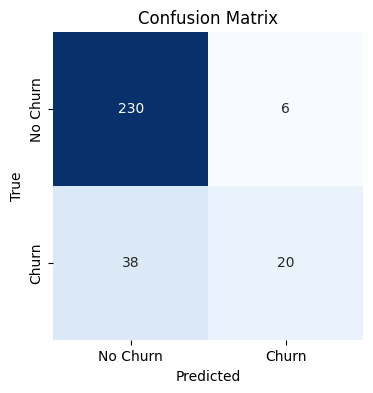

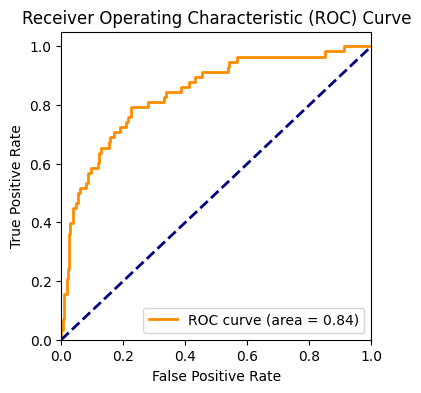

In [ ]:
# Fit the model
lrModel = LogisticRegression()
lrModel.fit(X_train, Y_train)
lr_predctions = lrModel.predict(X_test)

# Performanace Evaluation
lrAccuracy = accuracy_score(Y_test, lr_predctions)
lrPrecision = precision_score(Y_test, lr_predctions)
lrRecall = recall_score(Y_test, lr_predctions)
lrF1 = f1_score(Y_test, lr_predctions)

# Confusion Matrix
confusionMatrix = confusion_matrix(Y_test, lr_predctions)

# ROC-AUC Calculation
lr_classification_probability = lrModel.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
roc_auc = roc_auc_score(Y_test, lr_classification_probability)

# ROC Curve | false_positive_rate and true_positive_rate
false_pos_rate, true_pos_rate, _ = roc_curve(Y_test, lr_classification_probability)
roc_auc = auc(false_pos_rate, true_pos_rate)

print("Model : Logistic Regression")
print("Accuracy: ", lrAccuracy)
print("Precision: ", lrPrecision)
print("Recall: ", lrRecall)
print("F1 Score: ", lrF1)
print("Confusion Matrix: \n", confusionMatrix)
print("ROC-AUC: ", roc_auc)


# Confusion Matrix Plot
plt.figure(figsize=(4, 4))
sns.heatmap(confusionMatrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curev Plot
plt.figure(figsize=(4, 4))
plt.plot(false_pos_rate, true_pos_rate, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### K-Nearest-Neighbors


In [ ]:
# Fit the model
knnModel = KNeighborsClassifier()
knnModel.fit(X_train, Y_train)
knn_predctions = knnModel.predict(X_test)

# Performanace Evaluation
knnAccuracy = accuracy_score(Y_test, knn_predctions)
knnPrecision = precision_score(Y_test, knn_predctions)
knnRecall = recall_score(Y_test, knn_predctions)
knnF1 = f1_score(Y_test, knn_predctions)

# Confusion Matrix
confusionMatrix = confusion_matrix(Y_test, knn_predctions)

# ROC-AUC Calculation
knn_classification_probability = knnModel.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
roc_auc = roc_auc_score(Y_test, knn_classification_probability)

# ROC Curve | false_positive_rate and true_positive_rate
false_pos_rate, true_pos_rate, _ = roc_curve(Y_test, knn_classification_probability)
roc_auc = auc(false_pos_rate, true_pos_rate)

print("Model : K-Nearest-Neighbors")
print("Accuracy: ", knnAccuracy)
print("Precision: ", knnPrecision)
print("Recall: ", knnRecall)
print("F1 Score: ", knnF1)
print("Confusion Matrix: \n", confusionMatrix)
print("ROC-AUC: ", roc_auc)

Model : K-Nearest-Neighbors
Accuracy:  0.8027210884353742
Precision:  0.5
Recall:  0.1206896551724138
F1 Score:  0.19444444444444445
Confusion Matrix: 
 [[229   7]
 [ 51   7]]
ROC-AUC:  0.6093293395675045


### Support Vector Machine

In [ ]:
# Fit the model
svmModel = SVC()
svmModel.fit(X_train, Y_train)
svm_predctions = svmModel.predict(X_test)

# Performanace Evaluation
svmAccuracy = accuracy_score(Y_test, svm_predctions)
svmPrecision = precision_score(Y_test, svm_predctions)
svmRecall = recall_score(Y_test, svm_predctions)
svmF1 = f1_score(Y_test, svm_predctions)

# Confusion Matrix
confusionMatrix = confusion_matrix(Y_test, svm_predctions)

print("Model : Support Vector Machine")
print("Accuracy: ", svmAccuracy)
print("Precision: ", svmPrecision)
print("Recall: ", svmRecall)
print("F1 Score: ", svmF1)
print("Confusion Matrix: \n", confusionMatrix)

Model : Support Vector Machine
Accuracy:  0.8027210884353742
Precision:  0.0
Recall:  0.0
F1 Score:  0.0
Confusion Matrix: 
 [[236   0]
 [ 58   0]]


d:\Applications\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Naive Bayes

In [ ]:
# Fit the model
nbModel = GaussianNB()
nbModel.fit(X_train, Y_train)
nb_predctions = nbModel.predict(X_test)

# Performanace Evaluation
nbAccuracy = accuracy_score(Y_test, nb_predctions)
nbPrecision = precision_score(Y_test, nb_predctions)
nbRecall = recall_score(Y_test, nb_predctions)
nbF1 = f1_score(Y_test, nb_predctions)

# Confusion Matrix
confusionMatrix = confusion_matrix(Y_test, nb_predctions)

# ROC-AUC Calculation
nb_classification_probability = nbModel.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
roc_auc = roc_auc_score(Y_test, nb_classification_probability)

# ROC Curve | false_positive_rate and true_positive_rate
false_pos_rate, true_pos_rate, _ = roc_curve(Y_test, nb_classification_probability)
roc_auc = auc(false_pos_rate, true_pos_rate)

print("Model : Naive Bayes")
print("Accuracy: ", nbAccuracy)
print("Precision: ", nbPrecision)
print("Recall: ", nbRecall)
print("F1 Score: ", nbF1)
print("Confusion Matrix: \n", confusionMatrix)
print("ROC-AUC: ", roc_auc)

Model : Naive Bayes
Accuracy:  0.8163265306122449
Precision:  0.5344827586206896
Recall:  0.5344827586206896
F1 Score:  0.5344827586206896
Confusion Matrix: 
 [[209  27]
 [ 27  31]]
ROC-AUC:  0.7844827586206897


### Artificial Neural Network (MLPClassifier | Multilayer Perceptron Classifier)

In [ ]:
# Fit the model
annModel = MLPClassifier()
annModel.fit(X_train, Y_train)
ann_predctions = annModel.predict(X_test)

# Performanace Evaluation
annAccuracy = accuracy_score(Y_test, ann_predctions)
annPrecision = precision_score(Y_test, ann_predctions)
annRecall = recall_score(Y_test, ann_predctions)
annF1 = f1_score(Y_test, ann_predctions)

# Confusion Matrix
confusionMatrix = confusion_matrix(Y_test, ann_predctions)

# ROC-AUC Calculation
ann_classification_probability = annModel.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
roc_auc = roc_auc_score(Y_test, ann_classification_probability)

# ROC Curve | false_positive_rate and true_positive_rate
false_pos_rate, true_pos_rate, _ = roc_curve(Y_test, ann_classification_probability)
roc_auc = auc(false_pos_rate, true_pos_rate)

print("Model : Artificial Neural Network")
print("Accuracy: ", annAccuracy)
print("Precision: ", annPrecision)
print("Recall: ", annRecall)
print("F1 Score: ", annF1)
print("Confusion Matrix: \n", confusionMatrix)
print("ROC-AUC: ", roc_auc)

Model : Artificial Neural Network
Accuracy:  0.8299319727891157
Precision:  0.625
Recall:  0.3448275862068966
F1 Score:  0.4444444444444444
Confusion Matrix: 
 [[224  12]
 [ 38  20]]
ROC-AUC:  0.8264172998246639


d:\Applications\Python\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Gradient Boosting

In [ ]:
# Fit the model
gbModel = GradientBoostingClassifier()
gbModel.fit(X_train, Y_train)
gb_predctions = gbModel.predict(X_test)

# Performanace Evaluation
gbAccuracy = accuracy_score(Y_test, gb_predctions)
gbPrecision = precision_score(Y_test, gb_predctions)
gbRecall = recall_score(Y_test, gb_predctions)
gbF1 = f1_score(Y_test, gb_predctions)

# Confusion Matrix
confusionMatrix = confusion_matrix(Y_test, gb_predctions)

# ROC-AUC Calculation
gb_classification_probability = gbModel.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
roc_auc = roc_auc_score(Y_test, gb_classification_probability)

# ROC Curve | false_positive_rate and true_positive_rate
false_pos_rate, true_pos_rate, _ = roc_curve(Y_test, gb_classification_probability)
roc_auc = auc(false_pos_rate, true_pos_rate)

print("Model : Gradient Boosting")
print("Accuracy: ", gbAccuracy)
print("Precision: ", gbPrecision)
print("Recall: ", gbRecall)
print("F1 Score: ", gbF1)
print("Confusion Matrix: \n", confusionMatrix)
print("ROC-AUC: ", roc_auc)

Model : Gradient Boosting
Accuracy:  0.8129251700680272
Precision:  0.56
Recall:  0.2413793103448276
F1 Score:  0.3373493975903614
Confusion Matrix: 
 [[225  11]
 [ 44  14]]
ROC-AUC:  0.8176504967855055


### Voting Classifier

In [ ]:
randomForestModel = RandomForestClassifier()
xgboostModel = xgboost.XGBClassifier()
decisionTreeModel = DecisionTreeClassifier()

votingClassifierModel = VotingClassifier(
    estimators=[
        ("rf", randomForestModel),
        ("xgb", xgboostModel),
        ("dt", decisionTreeModel),
    ],
    voting="hard",
)

votingClassifierModel.fit(X_train, Y_train)
vc_predctions = votingClassifierModel.predict(X_test)

# Performanace Evaluation
vcAccuracy = accuracy_score(Y_test, vc_predctions)
vcPrecision = precision_score(Y_test, vc_predctions)
vcRecall = recall_score(Y_test, vc_predctions)
vcF1 = f1_score(Y_test, vc_predctions)

# Confusion Matrix
confusionMatrix = confusion_matrix(Y_test, vc_predctions)

print("Model : Voting Classifier")
print("Accuracy: ", vcAccuracy)
print("Precision: ", vcPrecision)
print("Recall: ", vcRecall)
print("F1 Score: ", vcF1)
print("Confusion Matrix: \n", confusionMatrix)

Model : Voting Classifier
Accuracy:  0.8061224489795918
Precision:  0.5238095238095238
Recall:  0.1896551724137931
F1 Score:  0.27848101265822783
Confusion Matrix: 
 [[226  10]
 [ 47  11]]


## Model Evaluation

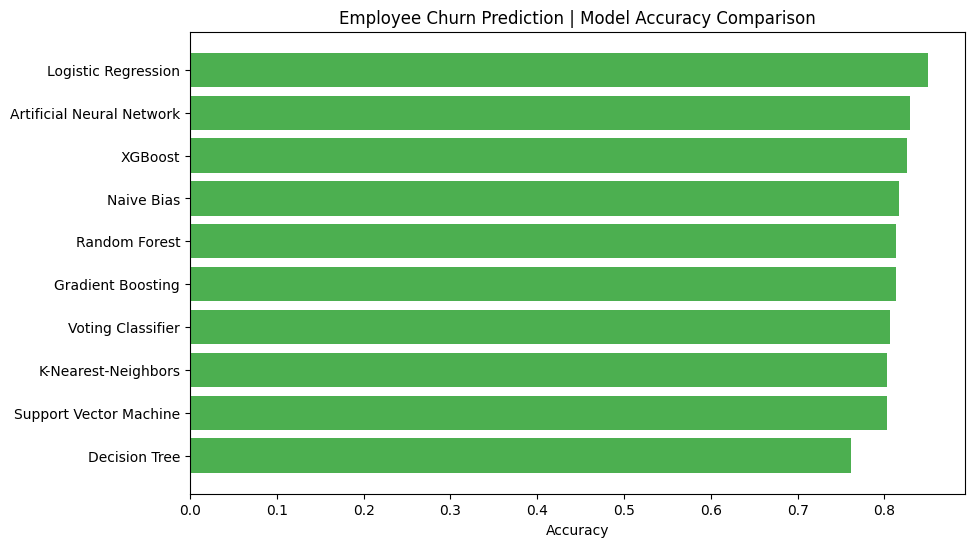

In [ ]:
# Model Evaluation based on Accuracy of each models
model_accuracy = {
    "Random Forest": rfAccuracy,
    "Decision Tree": dtAccuracy,
    "Gradient Boosting": gbAccuracy,
    "Logistic Regression": lrAccuracy,
    "Naive Bias": nbAccuracy,
    "Voting Classifier": vcAccuracy,
    "XGBoost": xgAccuracy,
    "K-Nearest-Neighbors": knnAccuracy,
    "Support Vector Machine": svmAccuracy,
    "Artificial Neural Network": annAccuracy,
}

sorted_order = dict(sorted(model_accuracy.items(), key=lambda item: item[1], reverse=True))
models = list(sorted_order.keys())
accuracy = list(sorted_order.values())

plt.figure(figsize=(10, 6))
plt.barh(models, accuracy, color='#4CAF50')
plt.xlabel('Accuracy')
plt.title('Employee Churn Prediction | Model Accuracy Comparison')
plt.gca().invert_yaxis() 
plt.show()

## Save Performance Metrics to Database

In [ ]:
per_metrics = { 
    "dataset_name": "IBM.csv",
    "metrics": [
        {
            "model_name": "Random Forest",
            "accuracy": rfAccuracy,
            "precisions": rfPrecision,
            "recall": rfRecall,
            "f1": rfF1,
        },
        {
            "model_name": "Decision Tree",
            "accuracy": dtAccuracy,
            "precisions": dtPrecision,
            "recall": dtRecall,
            "f1": dtF1,
        },
        {
            "model_name": "Gradient Boosting",
            "accuracy": gbAccuracy,
            "precisions": gbPrecision,
            "recall": gbRecall,
            "f1": gbF1,
        },
        {
            "model_name": "Logistic Regression",
            "accuracy": lrAccuracy,
            "precisions": lrPrecision,
            "recall": lrRecall,
            "f1": lrF1,
        },
        {
            "model_name": "Naive Bias",
            "accuracy": nbAccuracy,
            "precisions": nbPrecision,
            "recall": nbRecall,
            "f1": nbF1,
        },
        {
            "model_name": "Voting Classifier",
            "accuracy": vcAccuracy,
            "precisions": vcPrecision,
            "recall": vcRecall,
            "f1": vcF1,
        },
        {
            "model_name": "XGBoost",
            "accuracy": xgAccuracy,
            "precisions": xgPrecision,
            "recall": xgRecall,
            "f1": xgF1,
        },
        {
            "model": "K-Nearest-Neighbors",
            "accuracy": knnAccuracy,
            "precisions": knnPrecision,
            "recall": knnRecall,
            "f1": knnF1,
        },
        {
            "model_name": "Support Vector Machine",
            "accuracy": svmAccuracy,
            "precisions": svmPrecision,
            "recall": svmRecall,
            "f1": svmF1,
        },
        {
            "model_name": "Artificial Neural Network",
            "accuracy": annAccuracy,
            "precisions": annPrecision,
            "recall": annRecall,
            "f1": annF1,
        },
    ],
}

db = mysql.connector.connect(
  host="localhost",
  user="root",
  password="root",
  database="employee_churn"
)

cursor = db.cursor()
columns = "dataset_name, model_name, accuracy, precisions, recall, f1"
holder = ("%s, %s, %s, %s, %s, %s")
table = "performance_metrics"
query = "INSERT INTO " + table + " ("+ columns + ") VALUES ("+ holder + ")"
print(query)
try:
    for item in per_metrics["metrics"]:
        values = (per_metrics["dataset_name"], ) + tuple(item[mKey]  for mKey in item.keys())
        print(values)
        cursor.execute(query, values)

    db.commit()
    print("Data inserted successfully")

except Error as e:
    print("Error inserting rows : ", e)

cursor.close()
db.close()

INSERT INTO performance_metrics (dataset_name, model_name, accuracy, precisions, recall, f1) VALUES (%s, %s, %s, %s, %s, %s)
('IBM.csv', 'Random Forest', 0.8129251700680272, 0.6363636363636364, 0.1206896551724138, 0.2028985507246377)
('IBM.csv', 'Decision Tree', 0.7619047619047619, 0.375, 0.3103448275862069, 0.33962264150943394)
('IBM.csv', 'Gradient Boosting', 0.8129251700680272, 0.56, 0.2413793103448276, 0.3373493975903614)
('IBM.csv', 'Logistic Regression', 0.8503401360544217, 0.7692307692307693, 0.3448275862068966, 0.47619047619047616)
('IBM.csv', 'Naive Bias', 0.8163265306122449, 0.5344827586206896, 0.5344827586206896, 0.5344827586206896)
('IBM.csv', 'Voting Classifier', 0.8061224489795918, 0.5238095238095238, 0.1896551724137931, 0.27848101265822783)
('IBM.csv', 'XGBoost', 0.826530612244898, 0.6296296296296297, 0.29310344827586204, 0.4)
('IBM.csv', 'K-Nearest-Neighbors', 0.8027210884353742, 0.5, 0.1206896551724138, 0.19444444444444445)
('IBM.csv', 'Support Vector Machine', 0.80272